In [1]:
sd = 123 # Here sd means seed.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

from datetime import date

from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import importlib
import scripts.LstmStrategy as sl

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras import layers,Sequential
from tensorflow.keras.layers import LSTM,RepeatVector,TimeDistributed,Dense,Dropout
from keras.callbacks import EarlyStopping
%load_ext autoreload
%autoreload 2
#importlib.reload(ss) #above magic works so won't need to manual reload
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16, 6)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import tensorflow as tf
import numpy as np
import random as rn


np.random.seed(sd)
rn.seed(sd)
os.environ['PYTHONHASHSEED']=str(sd)

from keras import backend as K
tf.random.set_seed(sd)
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

In [2]:
sd = 123 # Here sd means seed.
mpl.rcParams['figure.figsize'] = (16, 6)

In [3]:
#data prepare
start=date(1990, 1, 1)
end=date(2020, 11, 16)

#stock_list=['ICE', 'WLTW']
stock_list=['BABA', 'BBY']
stock_pair=yf.download(stock_list, start, end, progress = False)

stock_pair=stock_pair[['Adj Close']].copy()
stock_pair.dropna(how='any', axis=0, inplace=True)
stock_pair.columns=stock_pair.columns.droplevel()
stock_pair.index=pd.DatetimeIndex(stock_pair.index)
#stock_pair.head()
dog_leash=stock_pair.copy()
smoothing='yes'
if smoothing=='yes':
        dog_leash=dog_leash.rolling(window=5).mean()
        dog_leash.dropna(inplace=True)
c=np.polyfit(dog_leash.iloc[:, 0], dog_leash.iloc[:, 1], 1)
dog_leash['Dog_leash']=dog_leash.iloc[:, 1]-c[0]*dog_leash.iloc[:, 0]
dog_leash=dog_leash[['Dog_leash']]
test_data=pd.merge(stock_pair, dog_leash, how='outer', on='Date')
test_data.dropna(how='any', axis=0, inplace=True)
test_data=test_data.reset_index()
test_data['realcombo']=-test_data.iloc[:,1]*c[0]+test_data.iloc[:,2]
test_data['realcombo_before_std']=test_data.realcombo
#standard
realcombo_mean=test_data.realcombo.mean()
realcombo_std=test_data.realcombo.std()
test_data.realcombo=(test_data.realcombo-test_data.realcombo.mean())/test_data.realcombo.std()


In [4]:
test_data

,Date,BABA,BBY,Dog_leash,realcombo,realcombo_before_std
0,2014-09-25,88.919998,27.560184,-6.259882,-0.756359,-6.245063
1,2014-09-26,90.459999,27.295015,-6.275845,-0.889751,-7.095704
2,2014-09-29,88.750000,27.883350,-6.192479,-0.695547,-5.857268
3,2014-09-30,88.849998,27.833630,-6.282101,-0.709305,-5.945006
4,2014-10-01,86.099998,27.029856,-6.169267,-0.671402,-5.703296
...,...,...,...,...,...,...
1542,2020-11-09,290.529999,111.000000,8.185868,0.308806,0.547472
1543,2020-11-10,266.540009,112.629997,8.394818,1.994621,11.297887
1544,2020-11-11,265.649994,114.559998,9.620435,2.350332,13.566250
1545,2020-11-12,264.309998,114.000000,9.590701,2.342403,13.515687


In [5]:
trendpredict=[]
count=-1

for i in range(1100,test_data.shape[0]-160):
    count=count+1
    if count%100==0 and count>1:
        print(f'completed 100. on iteration {i}')
    for sd in [123,789,456,329]:
        future=sl.build_model_and_predict(test_data,i,i+160,seed=sd)
        trend=sl.trendHelper(future)
        print(f'idx {i+160} seed {sd} predicted: {trend}')
        if trend != '-':
            break;
    trendpredict.append([i+160,test_data.iloc[i+160,0],trend,sd]) 
#trendpredict    
#profit_cumulative,transaction_list=sl.trend_prediction_to_transaction(trendpredict,test_data)
#print(profit_cumulative)

idx 1260 seed 123 predicted: DOWN
idx 1261 seed 123 predicted: -
idx 1261 seed 789 predicted: DOWN
idx 1262 seed 123 predicted: DOWN
idx 1263 seed 123 predicted: UP
idx 1264 seed 123 predicted: UP
idx 1265 seed 123 predicted: -
idx 1265 seed 789 predicted: UP
idx 1266 seed 123 predicted: -
idx 1266 seed 789 predicted: -
idx 1266 seed 456 predicted: -
idx 1266 seed 329 predicted: -
idx 1267 seed 123 predicted: DOWN
idx 1268 seed 123 predicted: -
idx 1268 seed 789 predicted: -
idx 1268 seed 456 predicted: -
idx 1268 seed 329 predicted: -
idx 1269 seed 123 predicted: -
idx 1269 seed 789 predicted: -
idx 1269 seed 456 predicted: -
idx 1269 seed 329 predicted: -
idx 1270 seed 123 predicted: -
idx 1270 seed 789 predicted: -
idx 1270 seed 456 predicted: UP
idx 1271 seed 123 predicted: -
idx 1271 seed 789 predicted: -
idx 1271 seed 456 predicted: -
idx 1271 seed 329 predicted: -
idx 1272 seed 123 predicted: UP
idx 1273 seed 123 predicted: UP
idx 1274 seed 123 predicted: -
idx 1274 seed 789 pre

idx 1397 seed 789 predicted: UP
idx 1398 seed 123 predicted: UP
idx 1399 seed 123 predicted: DOWN
idx 1400 seed 123 predicted: DOWN
idx 1401 seed 123 predicted: DOWN
idx 1402 seed 123 predicted: DOWN
idx 1403 seed 123 predicted: DOWN
idx 1404 seed 123 predicted: DOWN
idx 1405 seed 123 predicted: DOWN
idx 1406 seed 123 predicted: UP
idx 1407 seed 123 predicted: -
idx 1407 seed 789 predicted: UP
idx 1408 seed 123 predicted: -
idx 1408 seed 789 predicted: DOWN
idx 1409 seed 123 predicted: DOWN
idx 1410 seed 123 predicted: UP
idx 1411 seed 123 predicted: UP
idx 1412 seed 123 predicted: UP
idx 1413 seed 123 predicted: UP
idx 1414 seed 123 predicted: UP
idx 1415 seed 123 predicted: -
idx 1415 seed 789 predicted: -
idx 1415 seed 456 predicted: -
idx 1415 seed 329 predicted: -
idx 1416 seed 123 predicted: -
idx 1416 seed 789 predicted: -
idx 1416 seed 456 predicted: -
idx 1416 seed 329 predicted: -
idx 1417 seed 123 predicted: DOWN
idx 1418 seed 123 predicted: -
idx 1418 seed 789 predicted: -


In [6]:
trend_prediction=pd.DataFrame(trendpredict, columns=('day_index','lastdateIncludedInModel', 'trend_predict','seed'))
trend_prediction.to_csv('./data/BB_lstmmodel_trend_predict_1200_1546.csv')
#transaction_list_pd=pd.DataFrame(transaction_list,columns=('day_index','date','open_close','L/S','profit','trend_predicted','combo_price'))
#transaction_list_pd.to_csv('./data/lstmmodel_transaction_records_2500_3371.csv')

In [9]:
profit_cumulative,transaction_list=sl.trend_prediction_to_transaction(trendpredict,test_data)
print(profit_cumulative)
transaction_list_pd=pd.DataFrame(transaction_list,columns=('day_index','date','open_close','L/S','profit','trend_predicted','combo_price'))
transaction_list_pd.to_csv('./data/BB_lstmmodel_transaction_records_1200_1546.csv')

43.481936435657815


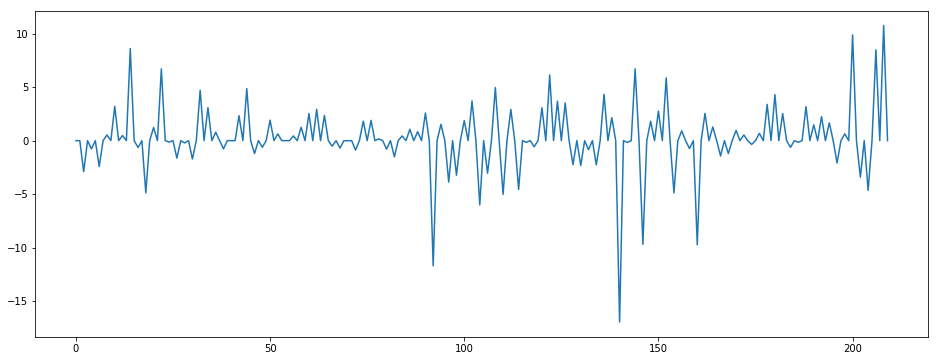

In [14]:
plt.plot(transaction_list_pd.profit)

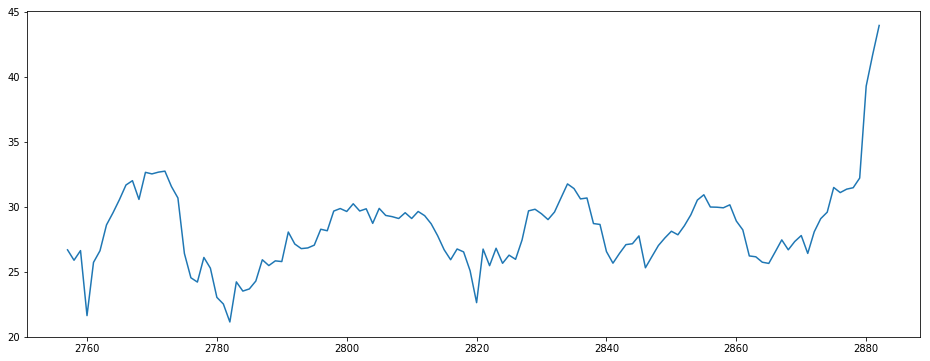

In [121]:
#2757	11/4/16 0:00	O	L	0	UP
#2883	5/9/17 0:00	C	L	15.44655386	DOWN
plt.plot(test_data.realcombo_before_std.iloc[2757:2883])

(201,)
Epoch 00055: early stopping
score on all train data is: 69.67%


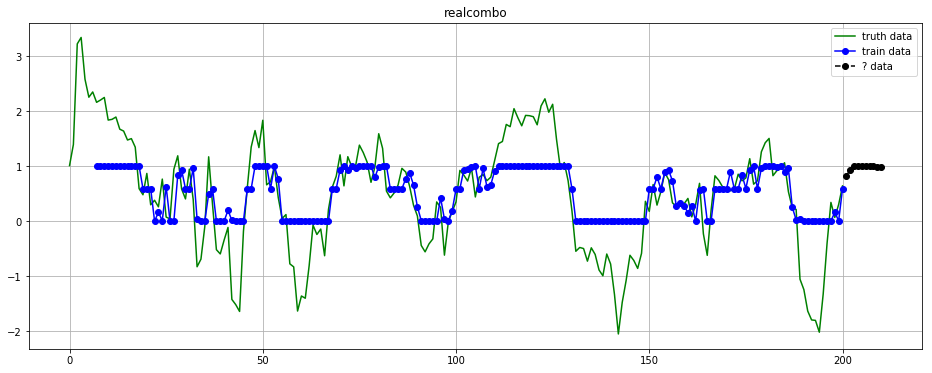

UP


In [30]:
sd=123
starting_point=3770-200
future=sl.build_model_and_predict_and_show(test_data,starting_point,starting_point+200,7)
print(sl.trendHelper(future))

[1.0, 0.99999976, 0.999996, 0.99994797, 0.55443513, 0.5649317, 0.34614605, 0.30958536, 0.23360142, 0.24463764]
[0, 0, 0, -1.3774043, 0, -0.6764257, 0, 0, 0]
[0, 0, -3.0088458120233574, 3.0088458120233574, -1.4776057932200277, 1.4776057932200277, 0, 0]


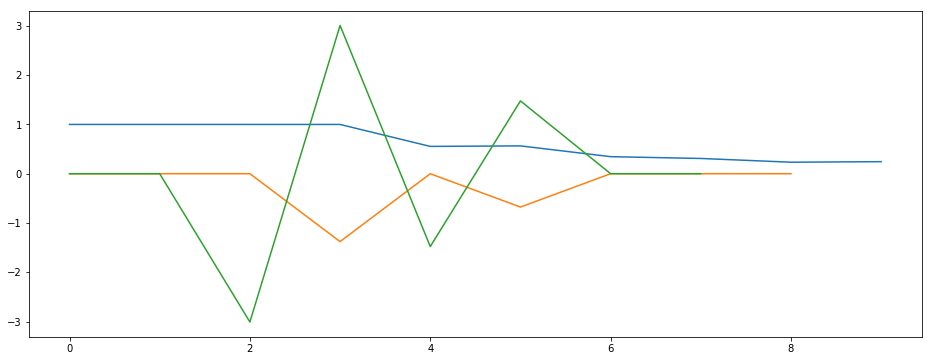

DOWN


In [11]:
future_diff1=sl.differentialHelper(future)
future_diff2=sl.differentialHelper(future_diff1)
print(future)
print(future_diff1)
print(future_diff2)
plt.plot(future)
plt.plot(future_diff1)
plt.plot(future_diff2)
plt.show()
print(sl.trendHelper(future))

# From trend to transaction

In [9]:
trendpredict=pd.read_csv('./data/lstmmodel_trend_predict_2200_3770.csv',header=0)
trendpredict.head()

,index,trend,seed
0,2200,DOWN,123
1,2201,UP,123
2,2202,DOWN,123
3,2203,DOWN,123
4,2204,DOWN,123


In [12]:
trendpredict.trend.value_counts()

UP      486
DOWN    271
-        36
Name: trend, dtype: int64

In [13]:
profit_cumulative,transaction_list=sl.trend_prediction_to_transaction(trendpredict.to_numpy(),test_data)

In [14]:
print(profit_cumulative)

264.0775977304936


In [16]:
transaction_list_pd=pd.DataFrame(transaction_list,columns=('day_index','date','open_close','L/S','profit','trend_predicted','combo_price'))
transaction_list_pd.to_csv('./data/lstmmodel_transaction_records_2200_3770.csv')

In [19]:
transaction_list_pd.set_index('date')

,day_index,open_close,L/S,profit,trend_predicted,combo_price
date,,,,,,
-,-1,-,-,0.000000,-,0.000000
2014-08-21 00:00:00,2200,O,S,0.000000,DOWN,41.785390
2014-08-22 00:00:00,2201,C,S,0.657800,UP,41.127590
2014-08-22 00:00:00,2201,O,L,0.000000,UP,41.127590
2014-08-25 00:00:00,2202,C,L,0.235860,DOWN,41.363450
...,...,...,...,...,...,...
2020-10-13 00:00:00,3747,O,L,0.000000,UP,42.442671
2020-10-14 00:00:00,3748,C,L,0.543436,DOWN,42.986107
2020-10-14 00:00:00,3748,O,S,0.000000,DOWN,42.986107


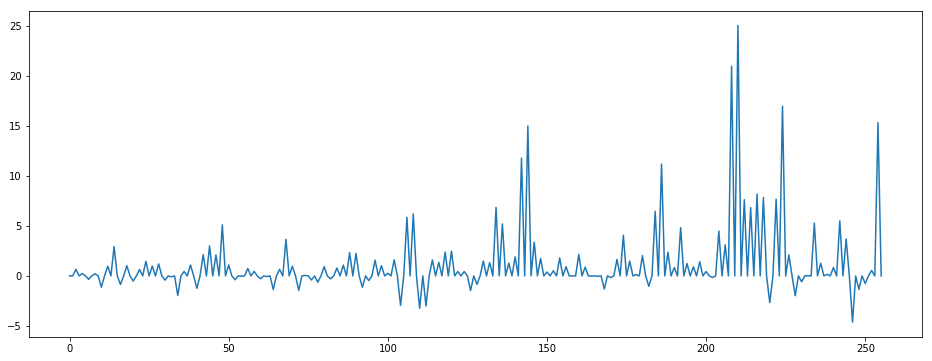

In [24]:
transaction_list_pd['profit'].plot()